In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [10, 7]

params = {'legend.fontsize': 14,
          'legend.handlelength': 2,
         }

plt.rcParams.update(params)

## 1. Обработка данных

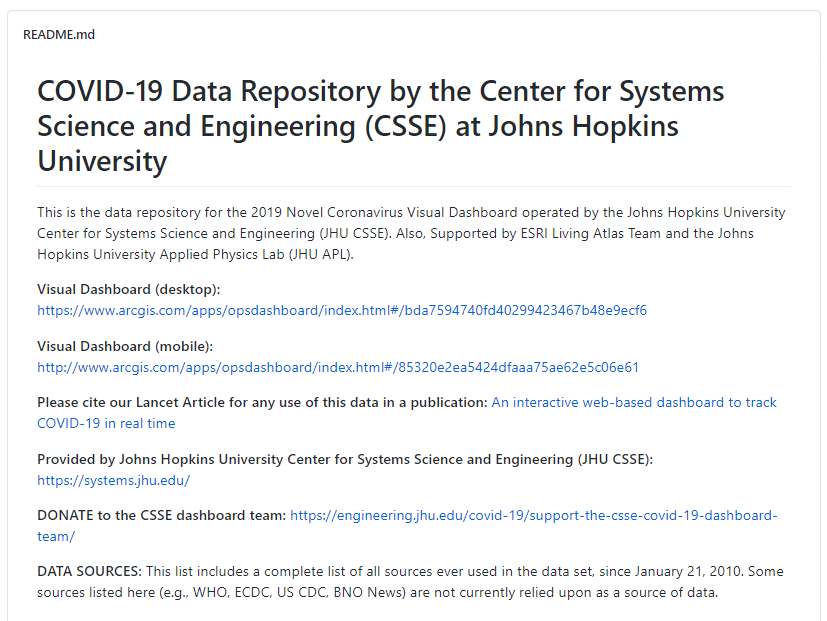

*Открытый источник - https://github.com/CSSEGISandData/COVID-19*

In [2]:
# Обработка данных по стране и по Нижнему Новгороду
# 1
rus = pd.read_csv("data_/covid19-russia-cases-scrf.csv")

rus.set_index('Date', inplace=True)
rus.index = pd.to_datetime(rus.index)

rus.drop(['Region/City-Eng', 'Region_ID'], axis=1, inplace=True)

NN = rus.loc[rus['Region/City'] == 'Нижегородская область']
rus = rus.resample('D').sum()

In [3]:
rus.tail()

,Day-Confirmed,Day-Deaths,Day-Recovered,Confirmed,Deaths,Recovered
Date,,,,,,
2020-07-27,5635.0,85.0,3063.0,817856.0,13354.0,603199.0
2020-07-28,5395.0,150.0,8869.0,823363.0,13503.0,612050.0
2020-07-29,5475.0,169.0,8069.0,828990.0,13673.0,620324.0
2020-07-30,5509.0,129.0,9310.0,834347.0,13801.0,629506.0
2020-07-31,5482.0,161.0,8747.0,839829.0,13962.0,638262.0


In [4]:
# 2
world = pd.read_csv("data_/WHO-COVID-19-global-data.csv")
world.drop([' Country_code', ' WHO_region'], axis=1, inplace=True)

rus2 = world.loc[world[' Country'] == 'Russian Federation']
del rus2[' Country']

rus2.set_index('Date_reported', inplace=True)
rus2.index = pd.to_datetime(rus2.index)

In [5]:
rus2['2020-07-27':'2020-07-31']

,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
Date_reported,,,,
2020-07-27,5635,818120,85,13354
2020-07-28,5395,823515,150,13504
2020-07-29,5475,828990,169,13673
2020-07-30,5509,834499,129,13802
2020-07-31,5482,839981,161,13963


In [6]:
# Дополнительная обработка данных по Нижнему Новгороду
del NN['Region/City']

# усредняем значения, чтобы не было скачкообразных графиков
NN_smooth = [
    NN['Day-Confirmed'].resample('4D').mean(),
    NN['Day-Deaths'].resample('4D').mean(),
    NN['Day-Recovered'].resample('4D').mean()   
]

## 2. Визуализация данных

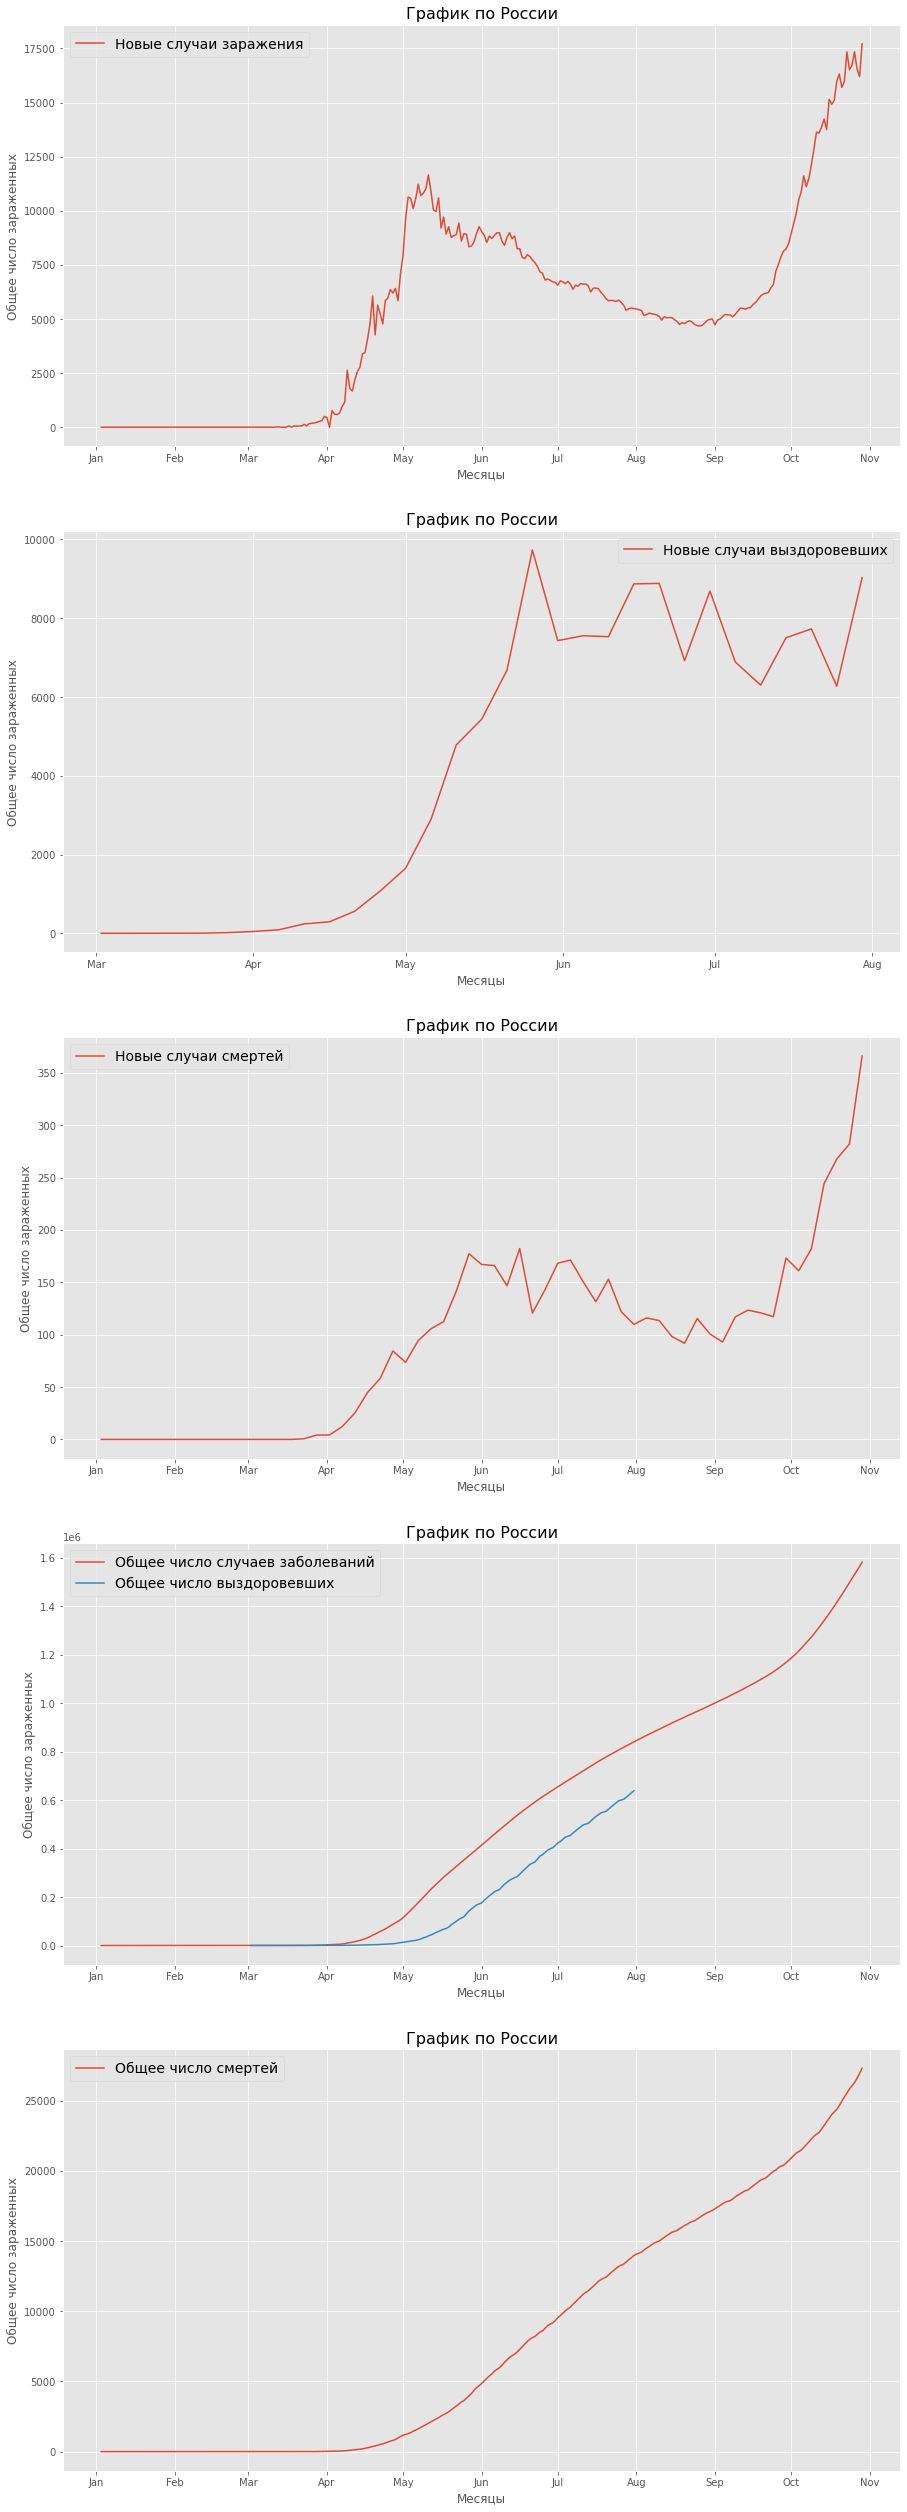

In [7]:
# Визуализация данных по стране
fig, ax = plt.subplots(5, 1, figsize=(15,45))

rus_period = rus.index
rus2_period = rus2.index

ax[0].plot(rus2_period, rus2[' New_cases'], label='Новые случаи заражения')
# Усредним значения, чтобы сгладить графики функций
ax[1].plot(rus['Day-Recovered'].resample('5D').mean(), label='Новые случаи выздоровевших')
ax[2].plot(rus2[' New_deaths'].resample('5D').mean(), label='Новые случаи смертей')

ax[3].plot(rus2_period, rus2[' Cumulative_cases'], label='Общее число случаев заболеваний')
ax[3].plot(rus_period, rus['Recovered'], label='Общее число выздоровевших')
ax[4].plot(rus2_period, rus2[' Cumulative_deaths'], label='Общее число смертей')

#set ticks every week
for i in range(5):
    ax[i].xaxis.set_major_locator(mdates.MonthLocator())
    #set major ticks format
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%b'))

    ax[i].set_xlabel('Месяцы')
    ax[i].set_ylabel('Общее число зараженных')
    ax[i].set_title('График по России', fontsize=16)

    leg = ax[i].legend();

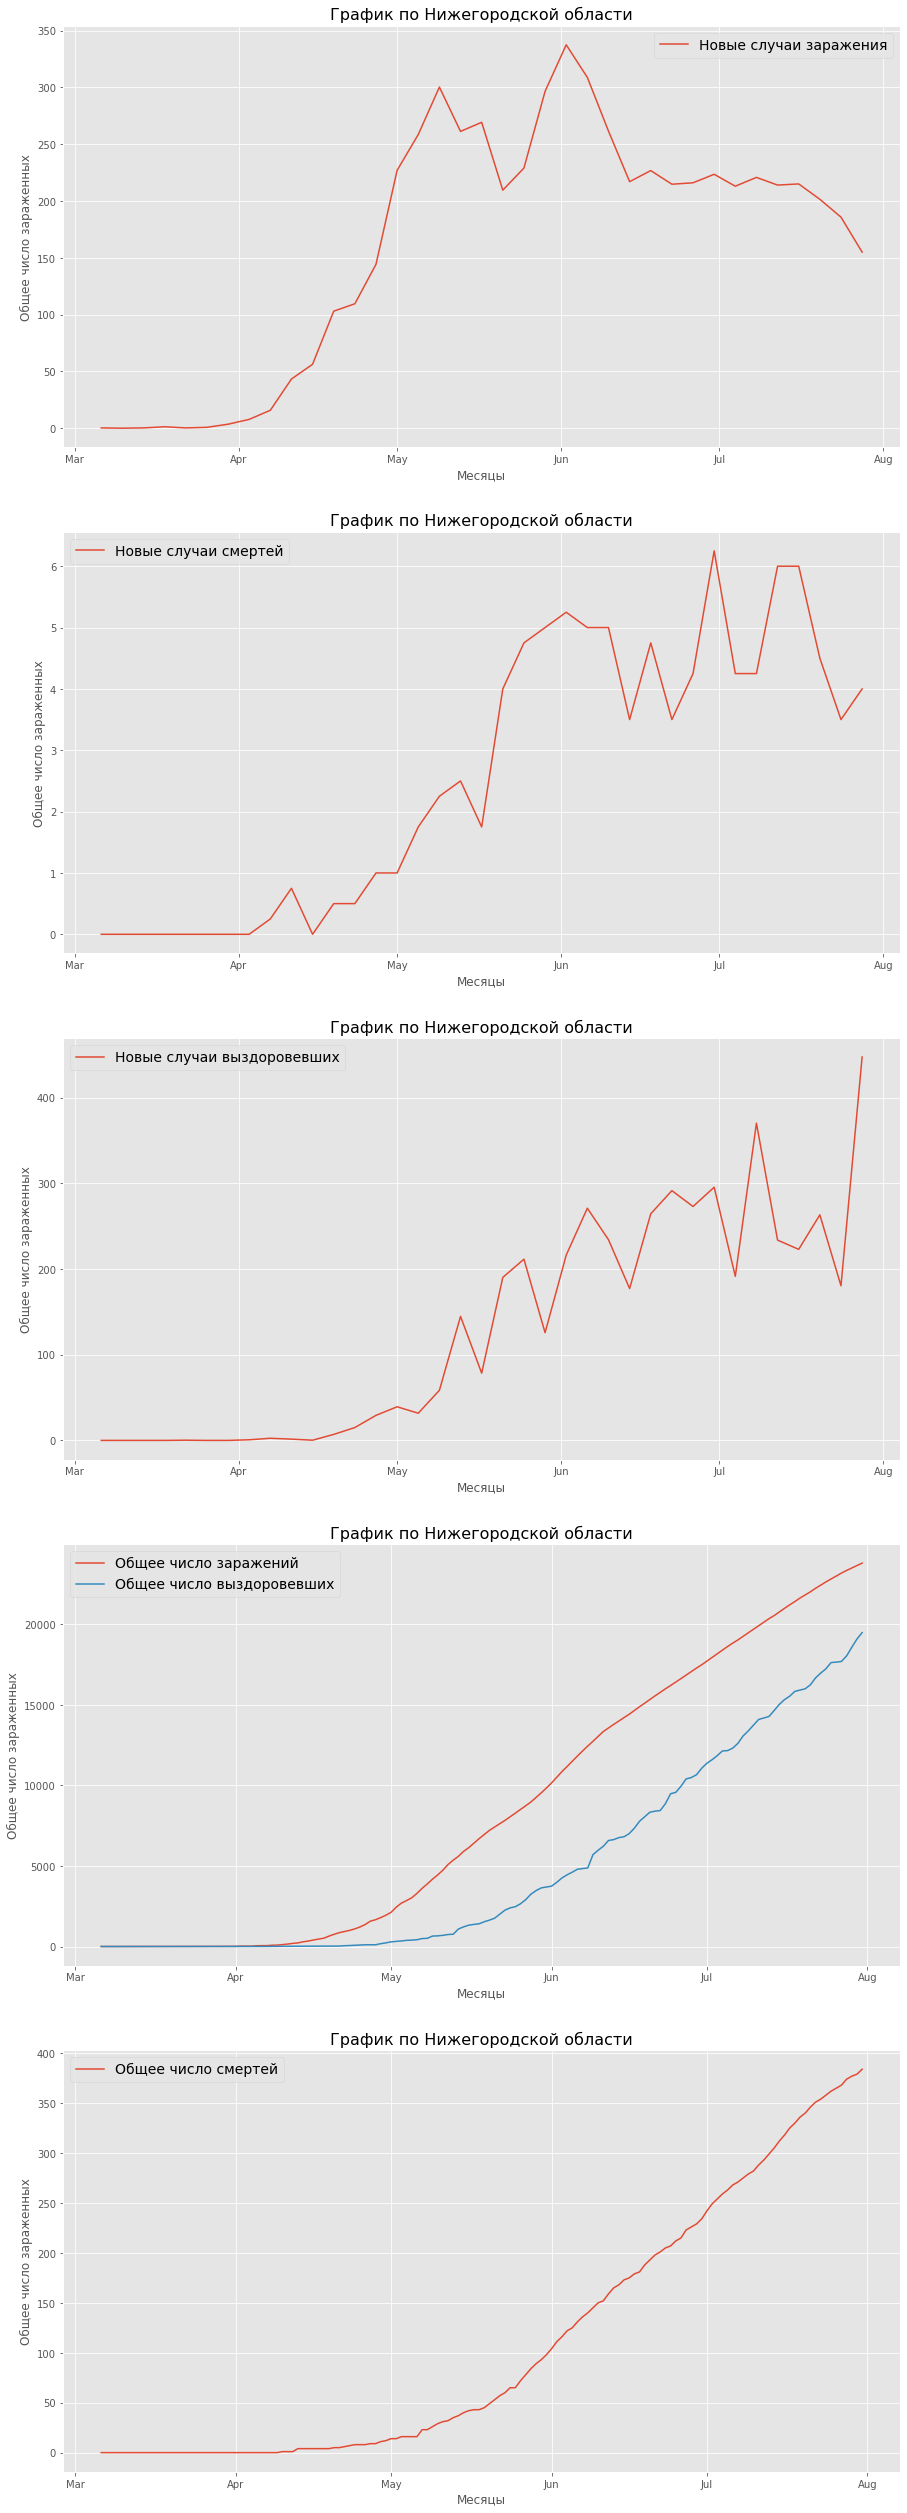

In [8]:
# Визуализация данных по Нижегородской области
fig, ax = plt.subplots(5, 1, figsize=(15,45))

NN_period = NN.index

ax[0].plot(NN_smooth[0], label='Новые случаи заражения')
ax[1].plot(NN_smooth[1], label='Новые случаи смертей')
ax[2].plot(NN_smooth[2], label='Новые случаи выздоровевших')

ax[3].plot(NN_period, NN['Confirmed'], label='Общее число заражений')
ax[3].plot(NN_period, NN['Recovered'], label='Общее число выздоровевших')
ax[4].plot(NN_period, NN['Deaths'], label='Общее число смертей')

for i in range(5):
    ax[i].xaxis.set_major_locator(mdates.MonthLocator())
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%b'))

    ax[i].set_xlabel('Месяцы')
    ax[i].set_ylabel('Общее число зараженных')
    ax[i].set_title('График по Нижегородской области', fontsize=16)

    leg = ax[i].legend();

## 3. Исследование моделей

`S` (susceptible) — восприимчивые,  
`E` (exposed) — зараженные в стадии инкубационного периода,  
`I` (infectious) — больные,  
`R` (recovered) — выздоровевшие,  
`D` (deaths) - умершие

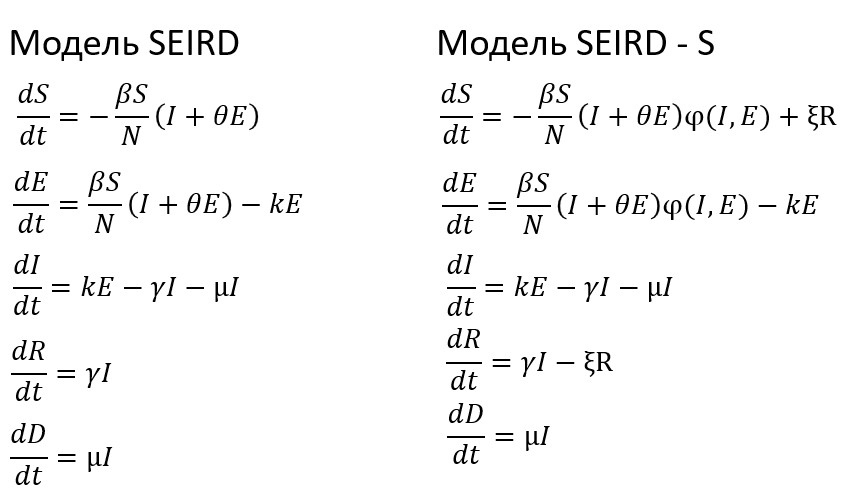

In [9]:
# Берем начальные условия с 01.06 по 31.07
start, end = '2020-06-01', '2020-07-31'

# Опишем популяцию по стране на группы реальными данными, в промежутке времени [start, end] 
S = rus2[start:end][' Cumulative_cases'].values.tolist()
R = rus[start:end]['Recovered'].values.tolist()
I = np.subtract(S, R)
E = 0.48 * I
D = rus2[start:end][' Cumulative_deaths'].values.tolist()

raw_data = np.array([S, E, I, R, D])

K = len(S)
T = pd.date_range(start=start, periods=K)

$\theta$ - это отношение передаточной способности облученного к инфицированному.  
Когда $\theta=0$, это означает, что инфекционная способность пациентов в латентном периоде игнорируется.  
Когда $\theta=0.4$, учитывая слабую способность передачи в латентный период  
Когда $\theta=1$, инфекционная способность пациентов в латентном периоде такая же, как и у пациентов с симптомами.  

$\gamma$ - это скорость высвобождения изоляции, она равняется 1/14, поскольку продолжительность карантина составляет 14 дней.

С ростом статистических данных меняется и оценка исследователями среднего инкубационныого периода, который изменился с
7 дней, определенных в январе, до 3 дней, оцененных летом. Это означает, что инфицированные люди с большей вероятностью проявят симптомы.    

$\kappa$ - это скорость трансформации от подверженного воздействию к инфицированному. Раньше она была равна 1/14, однако сейчас стала 1/3

In [10]:
# Остальные парамтеры зададим значениями, определенные ученными:
# (источник - https://www.who.int/emergencies/diseases/novel-coronavirus-2019)

beta = 3/14  
kappa = 1/3  
gamma = 1/14
mu = 0.08 
theta = 0.55
ksi = 0.6

# Неизвестные параметры для модели SEIRD
q = [beta, kappa, gamma, mu, theta]

# Определение границ параметров для искомого вектора q
bound_q = [(0, 1), (1/14, 1/3), (0, 1), (0, 0.2), (0, 1)]

# Неизвестные параметры для модели SEIRD-S
q2 = [beta, kappa, gamma, mu, theta, ksi]

# Определение границ параметров для искомого вектора q2
bound_q2 = [(0, 1), (1/14, 1/3), (0, 1), (0, 0.2), (0, 1), (0, 1)]

In [11]:
def pltplot(g_new, g, name):
    """
    Построение графиков функции
    """
    
    fig = plt.figure()
    ax = fig.add_subplot()
    
    ax.plot(T, g_new, label=name + ' pred')
    ax.plot(T, g, label=name +' real')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))

    ax.set_xlabel('день-месяц')
    ax.set_ylabel('Общее число зараженных')
    ax.set_title('График по России', fontsize=16)
    
    plt.legend(loc='best')
    plt.show();

In [12]:
def SEIRD(t, AA, q):
    """
    Вычисление математической модели SEIRD
    """
    
    beta, kappa, gamma, mu, theta = q
    S, E, I, R, D = AA
    N = S + E + I + R + D
    
    return t * np.array([
        -beta * S / N * (I + theta * E), \
        beta * S / N * (I + theta * E) - kappa * E, \
        kappa * E - gamma * I - mu * I,  \
        gamma * I, \
        mu * I
    ])

In [13]:
def SEIRD_S(t, AA, q2):
    """
    Вычисление математической модели SEIRD-S
    """
    
    # Константы (подобрали сами)
    alpha = 0.9
    K0 = 0.6
    
    beta, kappa, gamma, mu, theta, ksi = q2
    S, E, I, R, D = AA
    N = S + E + I + R + D
    
    # Функция, зависящая от числа заболевших
    phi = np.exp(-alpha * (I + theta * E) ** K0)
    
    return t * np.array([
        -beta * S / N * (I + theta * E) * phi + ksi * E, \
        beta * S / N * (I + theta * E) * phi - kappa * E, \
        kappa * E - gamma * I - mu * I,  \
        gamma * I - ksi * R, \
        mu * I
    ])

In [14]:
def Euler(func, q_12):
    """
    Нахождение численного решения математических моделей SEIRD и SEIRD_S методом Эйлера
    """
    
    AA = np.empty([5, K], dtype=np.double)
    
    AA[0, 0] = S[0]
    AA[1, 0] = E[0]
    AA[2, 0] = I[0]
    AA[3, 0] = R[0]
    AA[4, 0] = D[0]

    t = 0.1
    for i in range(1, K):
        AA[:, i] = AA[:, i - 1] + func(t, AA[:, i - 1], q_12)

    return AA

In [15]:
# Посмотрим как строятся графики функции моделей SEIRD и SEIRD-S на параметрах, заданных ученными

# Для SEIRD
S_, E_, I_, R_, D_ = Euler(SEIRD, q)
# Для SEIRD-S
S_s, E_s, I_s, R_s, D_s = Euler(SEIRD_S, q2)

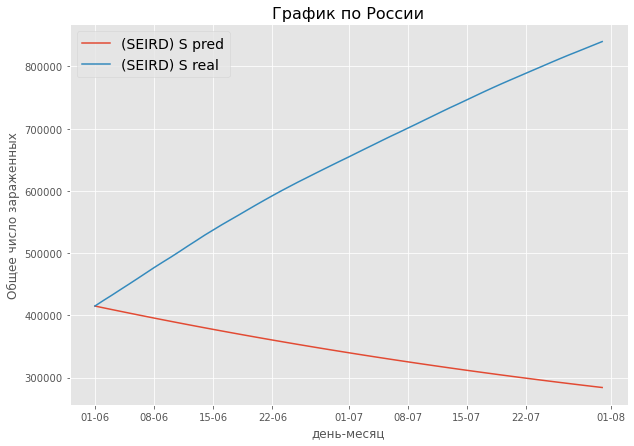

In [16]:
pltplot(S_, S, "(SEIRD) S")

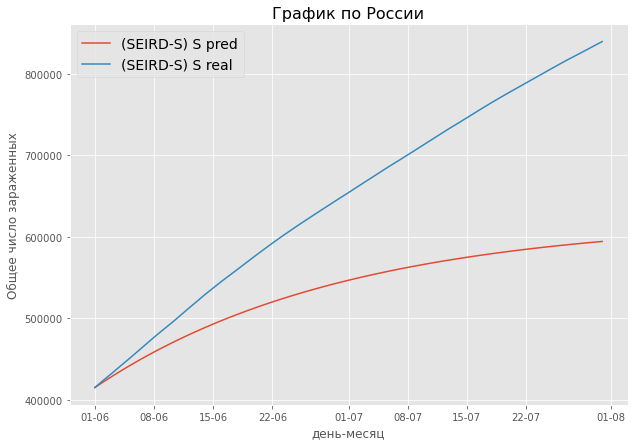

In [17]:
pltplot(S_s, S, "(SEIRD-S) S")

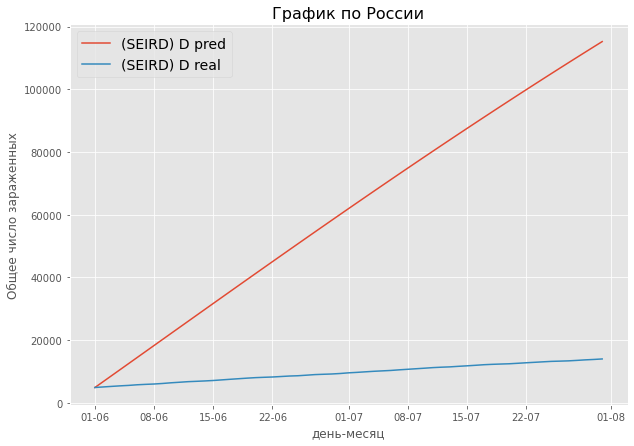

In [18]:
pltplot(D_, D, "(SEIRD) D")

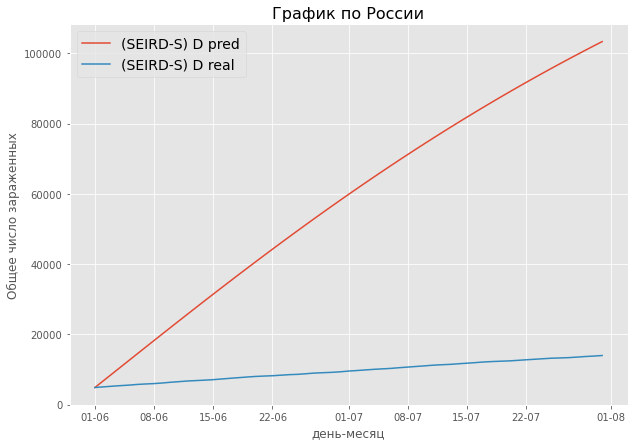

In [19]:
pltplot(D_s, D, "(SEIRD-S) D")

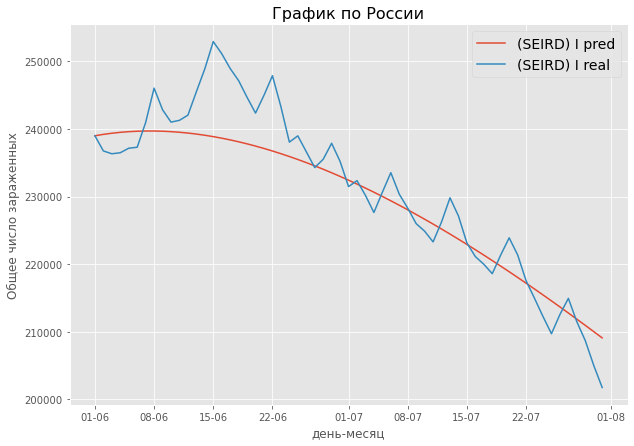

In [20]:
pltplot(I_, I, "(SEIRD) I")

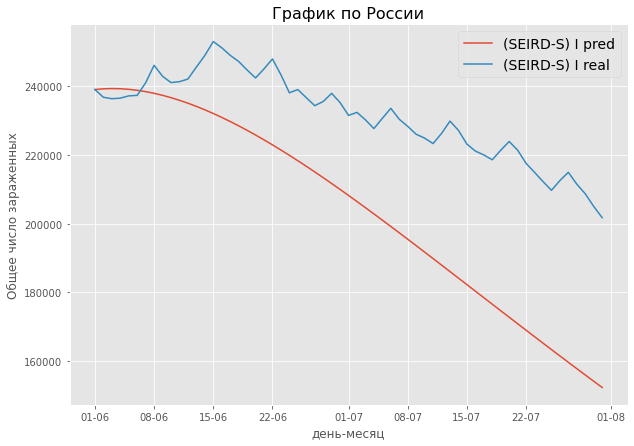

In [21]:
pltplot(I_s, I, "(SEIRD-S) I")

Теперь, поняв, что параметры, описанные ученными, описывают наши математические модели недостаточно хорошо.  
Поэтому применим метод оптимизации - `Дифференциальную Эволюцию (ДЭ)` для поиска наилучших коэф-тов q, q2.  
`Целевой функцией` у нас будет - `MSE` (будем анализировать погрешности моделей) 

Целевая функция принимает следующий вид:

$$
J(x) = {\sqrt{\frac{1}{K} * \sum_{i=1}^{K} (S_{pred}  - S_{real})^2 + \sum_{i=1}^{K} (D_{pred}  - D_{real})^2 + \sum_{i=1}^{K} (I_{pred}  - I_{real})^2 }}
$$

In [22]:
from scipy.optimize import differential_evolution
from scipy.optimize import minimize

# Целевые функции - MSE (будем анализировать погрешности моделей) 
def target_q(q):
    S_, E_, I_, R_, D_ = Euler(SEIRD, q)
    
    return np.sqrt(1 / K * (np.sum(S_ - S) ** 2 + \
                            np.sum(D_ - D) ** 2 + \
                            np.sum(I_ - I) ** 2)
                  )

def target_q2(q):
    S_, E_, I_, R_, D_ = Euler(SEIRD_S, q)
    
    return np.sqrt(1 / K * (np.sum(S_ - S) ** 2 + \
                            np.sum(D_ - D) ** 2 + \
                            np.sum(I_ - I) ** 2)
                  )

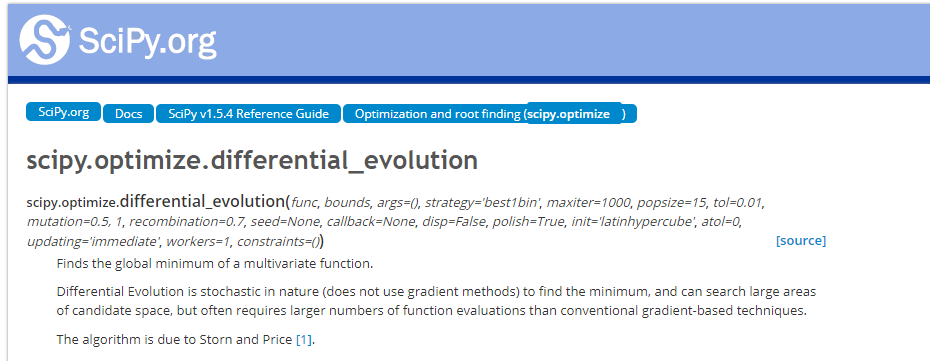

*Открытый источник - https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html*

In [23]:
# res = minimize(target_q2, q2, method='L-BFGS-B', bounds=bound_q2)
res = differential_evolution(target_q2, bound_q2)

res

     fun: 4.160207985448742e-11
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 90237
     nit: 1000
 success: False
       x: array([0.71181721, 0.18917823, 0.06948089, 0.00662008, 0.20078705,
       0.94291649])

In [24]:
S_new, E_new, I_new, R_new, D_new = Euler(SEIRD_S, res.x)

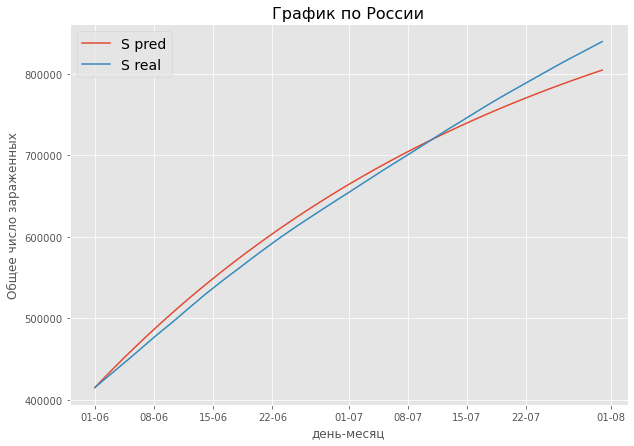

In [25]:
pltplot(S_new, S, "S")

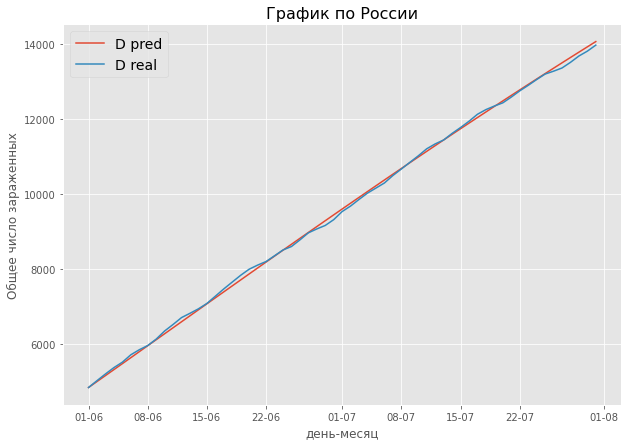

In [26]:
pltplot(D_new, D, "D")

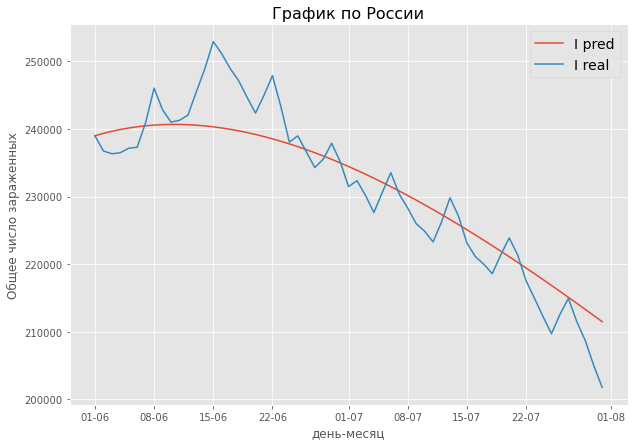

In [27]:
pltplot(I_new, I, "I")

## 4. Прогнозирование

Попробуем провести прогноз по Нижегородской области до НГ, используя метод SEIRD-S

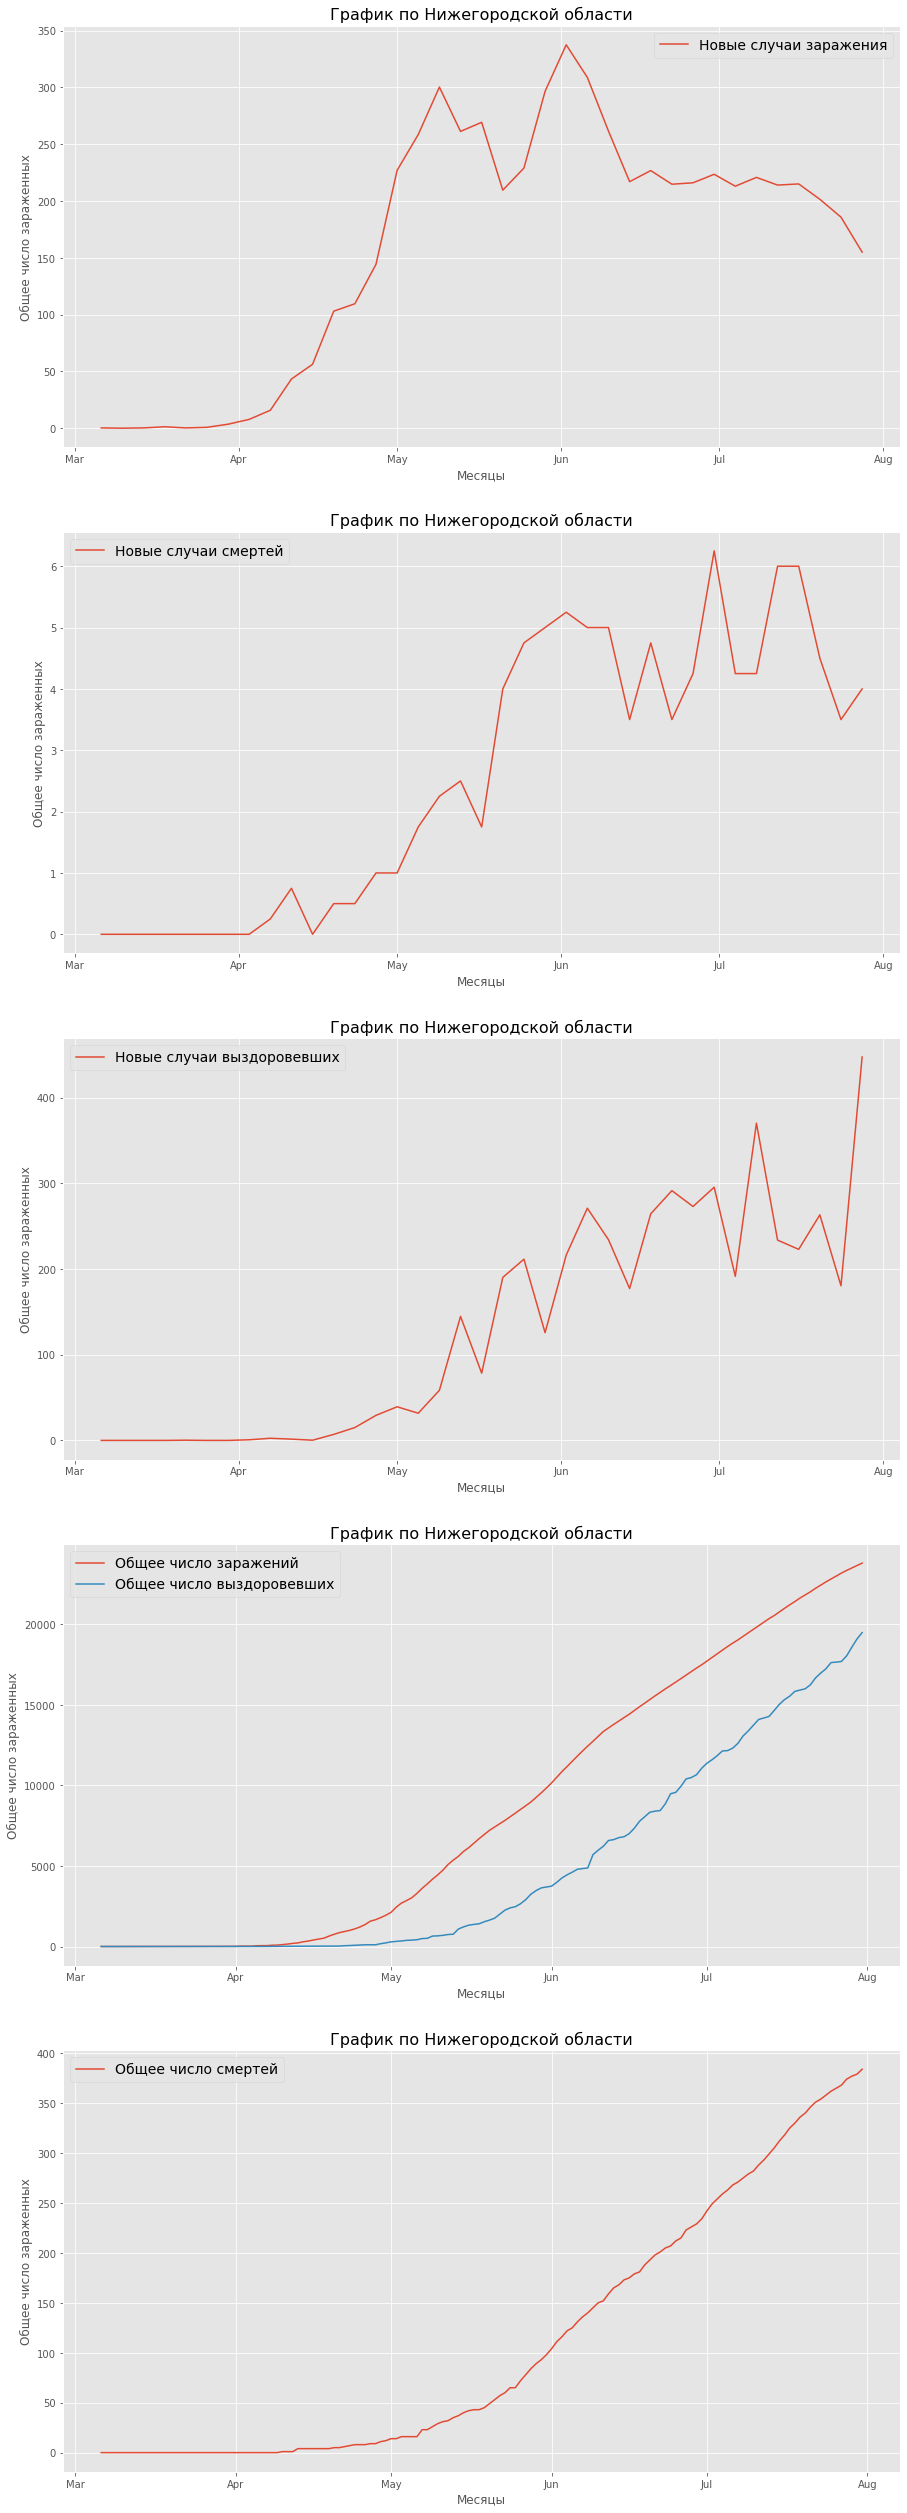

In [28]:
# Вспомни как выглядит ситуация в Нижегородской области до августа
fig, ax = plt.subplots(5, 1, figsize=(15,45))

NN_period = NN.index

ax[0].plot(NN_smooth[0], label='Новые случаи заражения')
ax[1].plot(NN_smooth[1], label='Новые случаи смертей')
ax[2].plot(NN_smooth[2], label='Новые случаи выздоровевших')

ax[3].plot(NN_period, NN['Confirmed'], label='Общее число заражений')
ax[3].plot(NN_period, NN['Recovered'], label='Общее число выздоровевших')
ax[4].plot(NN_period, NN['Deaths'], label='Общее число смертей')

for i in range(5):
    ax[i].xaxis.set_major_locator(mdates.MonthLocator())
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%b'))

    ax[i].set_xlabel('Месяцы')
    ax[i].set_ylabel('Общее число зараженных')
    ax[i].set_title('График по Нижегородской области', fontsize=16)

    leg = ax[i].legend();

In [29]:
# Повторяем те же действия, что и выше, только по Нижегородской области

# Берем нач условия с 01.07 по 31.07
start, end = '2020-07-01', '2020-07-31'

S = NN[start:end]['Confirmed'].values.tolist()
R = NN[start:end]['Recovered'].values.tolist()
I = np.subtract(S, R)
E = 0.48 * I
D = NN[start:end]['Deaths'].values.tolist()

K = len(S)
T = pd.date_range(start=start, periods=K)

In [30]:
res = differential_evolution(target_q2, bound_q2)

res

     fun: 3.28648470645798e-13
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 90237
     nit: 1000
 success: False
       x: array([0.42045449, 0.20620752, 0.14509415, 0.00830356, 0.26387172,
       0.84912233])

In [31]:
q_new = res.x

# Пробуем до НГ
AA = np.empty([5, K + 152], dtype=np.double)

AA[0, 0] = S[0]
AA[1, 0] = E[0]
AA[2, 0] = I[0]
AA[3, 0] = R[0]
AA[4, 0] = D[0]

t = 0.1
for i in range(1, K + 152):
    AA[:, i] = AA[:, i - 1] + SEIRD_S(t, AA[:, i - 1], q_new)
    
S_, E_, I_, R_, D_ = AA

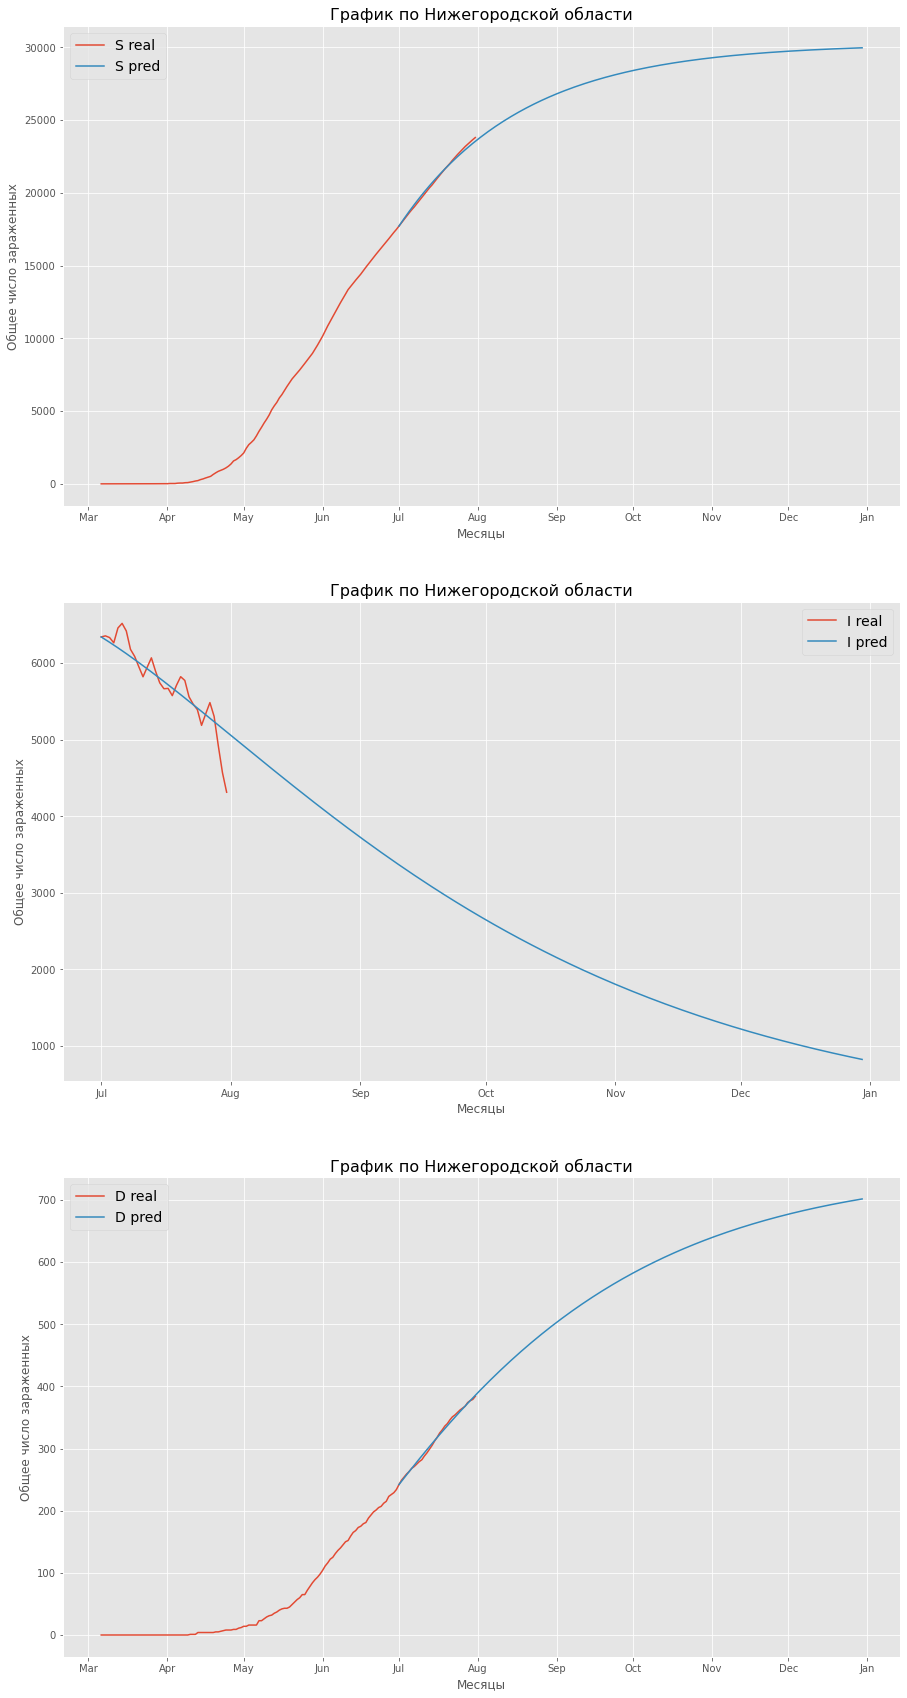

In [32]:
# Визуализируем прогноз
T_new = pd.date_range(start=start, periods=K + 152)

fig, ax = plt.subplots(3, 1, figsize=(15,30))

ax[0].plot(NN_period, NN['Confirmed'], label='S real')
ax[0].plot(T_new, S_, label='S pred')

ax[1].plot(T, I, label='I real')
ax[1].plot(T_new, I_, label='I pred')

ax[2].plot(NN_period, NN['Deaths'], label='D real')
ax[2].plot(T_new, D_, label='D pred')

for i in range(3):
    ax[i].xaxis.set_major_locator(mdates.MonthLocator())
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%b'))

    ax[i].set_xlabel('Месяцы')
    ax[i].set_ylabel('Общее число зараженных')
    ax[i].set_title('График по Нижегородской области', fontsize=16)

    leg = ax[i].legend();